## Recognition use CRNN
- 논문 github: https://github.com/bgshih/crnn#train-a-new-model
- python ver github: https://github.com/meijieru/crnn.pytorch

In [11]:
# 모듈 import
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
!pip install lmdb
import lmdb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 7.6 MB/s eta 0:00:00


In [3]:
# CRNN pytorch version github clone
!git clone https://github.com/meijieru/crnn.pytorch
%cd crnn.pytorch

Cloning into 'crnn.pytorch'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 95 (delta 28), reused 27 (delta 22), pack-reused 47
Unpacking objects: 100% (95/95), 44.97 KiB | 1.45 MiB/s, done.


/content/crnn.pytorch


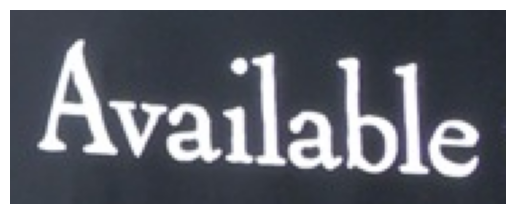

loading pretrained model from ./data/crnn.pth
Traceback (most recent call last):
  File "/content/crnn.pytorch/demo.py", line 18, in <module>
    model.load_state_dict(torch.load(model_path))
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 791, in load
    with _open_file_like(f, 'rb') as opened_file:
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 271, in _open_file_like
    return _open_file(name_or_buffer, mode)
  File "/usr/local/lib/python3.10/dist-packages/torch/serialization.py", line 252, in __init__
    super().__init__(open(name, mode))
FileNotFoundError: [Errno 2] No such file or directory: './data/crnn.pth'


In [13]:
img_path = '/content/crnn.pytorch/data/demo.png'
plt.imshow(np.array(Image.open(img_path).convert('RGB')))
plt.axis('off'); plt.show()
!python /content/crnn.pytorch/demo.py

In [ ]:
%cd crnn.pytorch/data
!wget https://github.com/bgshih/crnn/raw/master/data/demo2.jpg
# /content/crnn.pytorch/demo.py의 demo.jpg를 demo2.jpg로 변경

In [ ]:
img_path = '/content/crnn.pytorch/data/demo1.jpg'
plt.imshow(np.array(Image.open(img_path).convert('RGB')))
plt.axis('off'); plt.show()
!python /content/crnn.pytorch/demo.py

## OCR use EasyOCR

In [ ]:
pip install easyocr

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

In [5]:
import imutils
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
from easyocr import Reader
import cv2
import requests
from PIL import ImageFont, ImageDraw, Image

ModuleNotFoundError: ignored

In [ ]:
def plt_imshow(imgs, titles, fig_s=(8,5)):
    if len(imgs)%2==0: l = len(imgs)//2
    else: l=len(imgs)//2+1
    fig, ax = plt.subplots(2,l, figsize=fig_s, constrained_layout=True)
    ax = ax.flatten()
    for i,img in enumerate(imgs):
        if len(img.shape)<=2:
            rgbimg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else: rgbimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[i].imshow(rgbimg)
        ax[i].set_title(titles[i])
        ax[i].axis('off')
    plt.show()

def make_scan_img(img, width, ksize=(5,5), min_thresh=75, max_thresh=200, findCnt=None):
    ori_img = img.copy()
    img = imutils.resize(img, width=width)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, ksize, 0)
    edged = cv2.Canny(blurred, min_thresh, max_thresh)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)

    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02*peri, True)
        if len(approx)==4:
            findCnt = approx; break

    if findCnt is None: 
        raise Exception('Could not find outline.')

    output = img.copy()
    cv2.drawContours(output, [findCnt], -1, (0,255,0), 2)
    ratio = ori_img.shape[1]/float(img.shape[1])
    trans_img = four_point_transform(ori_img, findCnt.reshape(4,2)*ratio)

    img_title_li = ['img','gray','blurred','edged','outline','transform']
    img_li = [img, gray, blurred, edged, output, trans_img]
    plt_imshow(img_li, img_title_li)
    return trans_img

In [ ]:
url = 'https://user-images.githubusercontent.com/69428232/155486780-55525c3c-8f5f-4313-8590-dd69d4ce4111.jpg'

img_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
img = cv2.imdecode(img_nparray, cv2.IMREAD_COLOR)
trans_img = make_scan_img(img, width=200, ksize=(5, 5), min_thresh=20, max_thresh=100)

In [ ]:
langs = ['ko', 'en']
print("[INFO] OCR'ing input image...")
reader = Reader(lang_list=langs, gpu=True)
results = reader.readtext(trans_img)
results

In [ ]:
simple_results = reader.readtext(trans_img, detail=0)
simple_results

In [ ]:
def putText(cv_img, text, x, y, color=(0,0,0), font_s=22):
    font = ImageFont.truetype('/usr/share/fonts/truetype/nanum/NanumGothicBold.ttf', font_s)
    img = Image.fromarray(cv_img)
    draw = ImageDraw.Draw(img)
    draw.text((x, y), text, font=font, fill=color)
    cv_img = np.array(img)
    return cv_img

for (bbox, text, prob) in results:
    # print('{:.4f}: {}'.format(prob, text))
    pts = [(int(p[0]), int(p[1])) for p in bbox]
    cv2.rectangle(trans_img, pts[0], pts[2], (0,255,0), 2)
    trans_img = putText(trans_img, text, pts[0][0], pts[0][1]-60, (0,255,0), 50)
plt.imshow(trans_img)
plt.axis('off')
plt.show()